In [19]:
import os
import cv2
import re
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


Patients: ['L067', 'L096', 'L109', 'L143', 'L192', 'L286', 'L291', 'L310', 'L333', 'L506']

Use patient: L067
Full dir: C:\Users\jfbos\Desktop\Preprocessed_512x512\512\Full Dose\1mm\Sharp Kernel (D45)\L067
Low  dir: C:\Users\jfbos\Desktop\Preprocessed_512x512\512\Quarter Dose\1mm\Sharp Kernel (D45)\L067

FD slice count: 560
QD slice count: 560

Full path: C:\Users\jfbos\Desktop\Preprocessed_512x512\512\Full Dose\1mm\Sharp Kernel (D45)\L067\L067_FD_1_SHARP_1.CT.0002.0201.2016.01.21.18.11.40.977560.404633815.png
Low  path: C:\Users\jfbos\Desktop\Preprocessed_512x512\512\Quarter Dose\1mm\Sharp Kernel (D45)\L067\L067_QD_1_SHARP_1.CT.0004.0201.2016.01.21.18.12.19.650560.405046876.png
Full shape: (512, 512)
Low  shape: (512, 512)


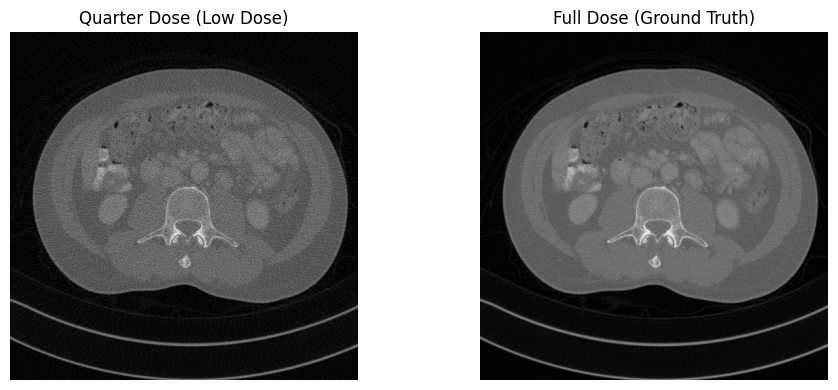

In [22]:

# ====== 1. set your root directory (change to your path) ======
#root = r"C:\Users\jfbos\Desktop\Preprocessed_256x256\256"
root = r"C:\Users\jfbos\Desktop\Preprocessed_512x512\512"

full_root = os.path.join(root, "Full Dose", "1mm", "Sharp Kernel (D45)")
low_root  = os.path.join(root, "Quarter Dose", "1mm", "Sharp Kernel (D45)")

# ====== 2. list patient folders ======
patients = sorted(os.listdir(full_root))
print("Patients:", patients[:10])

# ====== 3. select patient (first one) ======
pid = patients[0]
full_dir = os.path.join(full_root, pid)
low_dir  = os.path.join(low_root,  pid)

print("\nUse patient:", pid)
print("Full dir:", full_dir)
print("Low  dir:", low_dir)

# ====== 4. load FD/QD file lists (sorted and paired) ======
full_files = sorted([f for f in os.listdir(full_dir) if f.endswith(".png")])
low_files  = sorted([f for f in os.listdir(low_dir)  if f.endswith(".png")])

print("\nFD slice count:", len(full_files))
print("QD slice count:", len(low_files))

# ====== 5. check if counts match ======
assert len(full_files) == len(low_files)

# ====== 6. get one slice ======
idx = 200
full_path = os.path.join(full_dir, full_files[idx])
low_path  = os.path.join(low_dir,  low_files[idx])

print("\nFull path:", full_path)
print("Low  path:", low_path)

# ====== 7. load img ======
full_img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
low_img  = cv2.imread(low_path,  cv2.IMREAD_GRAYSCALE)

print("Full shape:", full_img.shape)
print("Low  shape:",  low_img.shape)

# ====== 8. display ======
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Quarter Dose (Low Dose)")
plt.imshow(low_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Full Dose (Ground Truth)")
plt.imshow(full_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


### Peak Signal-to-Noise Ratio (PSNR)


$$\text{PSNR} = 10 \log_{10} \left( \frac{MAX_I^2}{\mathrm{MSE}} \right)$$

$$\mathrm{MSE} = \frac{1}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} (I(i,j) - K(i,j))^2$$

- \($I$\) = ground truth（Full Dose）
- \($K$\) = reconstructed image（denoised output）
- \($MAX_I$\) = maximum value a img can get（8-bit → 255）


### Structural Similarity Index (SSIM)



$$
\text{SSIM}(x, y) = 
\frac{(2\mu_x \mu_y + C_1)(2\sigma_{xy} + C_2)}
     {(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$


- \( $\mu_x$, $\mu_y$ \)：means of images \(x\) and \(y\) 
- \( $\sigma_x^2$, $\sigma_y^2$ \): variances   
- \( $\sigma_{xy}$ \)： covariance    
- \( $C_1$, $C_2$ \)：constants to stabilize division


In [23]:
gaussian = cv2.GaussianBlur(low_img, (5,5), 0)
median = cv2.medianBlur(low_img, 5)
def psnr(img1, img2):
  
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))
def ssim(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    mu1 = img1.mean()
    mu2 = img2.mean()
    sigma1 = img1.var()
    sigma2 = img2.var()
    sigma12 = ((img1 - mu1) * (img2 - mu2)).mean()

    numerator   = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1**2 + mu2**2 + C1) * (sigma1 + sigma2 + C2)

    return numerator / denominator


low = low_img        # noisy image
full = full_img      # ground truth

print("PSNR (original):", psnr(full, low))
print("SSIM (original):", ssim(full, low))


# Baseline: Gaussian Blur

n = 5
baseline = cv2.GaussianBlur(low, (n, n), 0)

print("PSNR (Gaussian):", psnr(full, baseline))
print("SSIM (Gaussian):", ssim(full, baseline))


baseline2 = cv2.medianBlur(low, n)

print("PSNR (median):", psnr(full, baseline2))
print("SSIM (median):", ssim(full, baseline2))

PSNR (original): 27.47738735161432
SSIM (original): 0.9764605294799861
PSNR (Gaussian): 29.8907008424635
SSIM (Gaussian): 0.9862880553539222
PSNR (median): 29.55040155264691
SSIM (median): 0.9854220075963049


In [4]:


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [5]:
class CTLowDoseDataset(Dataset):
    def __init__(self, root):
        root = r"C:\Users\jfbos\Desktop\Preprocessed_256x256\256"
        self.full_root = os.path.join(root, "Full Dose", "1mm", "Sharp Kernel (D45)")
        self.low_root  = os.path.join(root, "Quarter Dose", "1mm", "Sharp Kernel (D45)")

        self.pairs = []
        patients = sorted(os.listdir(self.full_root))

        for pid in patients:
            full_dir = os.path.join(self.full_root, pid)
            low_dir  = os.path.join(self.low_root,  pid)
            if not os.path.isdir(full_dir):
                continue

            full_files = sorted([f for f in os.listdir(full_dir) if f.endswith(".png")])
            low_files  = sorted([f for f in os.listdir(low_dir)  if f.endswith(".png")])

            for f_name, l_name in zip(full_files, low_files):
                self.pairs.append((
                    os.path.join(low_dir,  l_name),   # noisy
                    os.path.join(full_dir, f_name),   # clean
                ))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        low_path, full_path = self.pairs[idx]

        low_img  = cv2.imread(low_path,  cv2.IMREAD_GRAYSCALE)
        full_img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

        # [H,W] → [1,H,W]，並 normal 到 [-1, 1]
        low_img  = (low_img.astype(np.float32)  / 127.5) - 1.0
        full_img = (full_img.astype(np.float32) / 127.5) - 1.0

        low  = torch.from_numpy(low_img)[None, ...]   # [1,H,W]
        full = torch.from_numpy(full_img)[None, ...]  # [1,H,W]
        return low, full


In [6]:
#root = r"C:\Users\jfbos\Desktop\Preprocessed_256x256\256"
dataset = CTLowDoseDataset(root)
print("Total pairs:", len(dataset))
low, full = dataset[0]
print(low.shape, full.shape, low.min().item(), low.max().item())


Total pairs: 5936
torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) -1.0 0.7098039388656616


In [7]:

# ----- ResBlock -----
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_emb = nn.Linear(time_dim, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = h + self.time_emb(t_emb)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        return F.silu(h + self.skip(x))

# ----- Time Embedding -----
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin1 = nn.Linear(dim, dim)
        self.lin2 = nn.Linear(dim, dim)

    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(torch.arange(half, device=t.device) * -torch.log(torch.tensor(10000.0)) / (half - 1))
        args = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        emb = self.lin1(emb)
        emb = F.silu(emb)
        emb = self.lin2(emb)
        return emb

# ----- Corrected UNet for 512×512 -----
class SimpleUNet(nn.Module):
    def __init__(self, time_dim=128):
        super().__init__()

        self.time_mlp = TimeEmbedding(time_dim)

        # in: x_t + low = 2 channels
        self.in_conv = nn.Conv2d(2, 64, 3, padding=1)

        # Encoder
        self.down1 = ResBlock(64, 128, time_dim)   # 512×512
        self.pool1 = nn.AvgPool2d(2)               # 512→256

        self.down2 = ResBlock(128, 256, time_dim)  # 256×256
        self.pool2 = nn.AvgPool2d(2)               # 256→128

        self.mid = ResBlock(256, 256, time_dim)    # 128×128

        # Decoder
        self.up1 = ResBlock(256 + 256, 256, time_dim)  # 128→128
        self.up2 = ResBlock(256 + 128, 128, time_dim)  # 256→256
        self.up3 = ResBlock(128 + 64, 64, time_dim)    # 512→512

        self.out_conv = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x_t, low, t):
        t_emb = self.time_mlp(t)

        x = torch.cat([x_t, low], 1)       # [B,2,512,512]
        x1 = self.in_conv(x)              # [B,64,512,512]

        d1 = self.down1(x1, t_emb)        # [B,128,512,512]
        p1 = self.pool1(d1)               # [B,128,256,256]

        d2 = self.down2(p1, t_emb)        # [B,256,256,256]
        p2 = self.pool2(d2)               # [B,256,128,128]

        m = self.mid(p2, t_emb)           # [B,256,128,128]

        # Decoder
        u1 = F.interpolate(m, scale_factor=2, mode="nearest")   # 128→256
        u1 = torch.cat([u1, d2], dim=1)                         # [B,512,256,256]
        u1 = self.up1(u1, t_emb)

        u2 = F.interpolate(u1, scale_factor=2, mode="nearest")  # 256→512
        u2 = torch.cat([u2, d1], dim=1)                         # [B,256+128,512,512]
        u2 = self.up2(u2, t_emb)

        u3 = torch.cat([u2, x1], dim=1)                         # cat input  features
        out = self.up3(u3, t_emb)

        return self.out_conv(out)

In [8]:
# ------------ diffusion schedule ------------
T = 1  
betas = torch.linspace(1e-4, 0.02, T, device=device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)   # \bar{alpha}_t
def train_diffusion(root, epochs=1, batch_size=4, lr=1e-4, device="cuda"):
    dataset = CTLowDoseDataset(root)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = SimpleUNet().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        for low, full in loader:
            low  = low.to(device)
            full = full.to(device)

            b = full.size(0)
            t = torch.randint(0, T, (b,), device=device)
            a_bar = alpha_bars[t].view(b, 1, 1, 1).to(device)

            eps = torch.randn_like(full)
            x_t = torch.sqrt(a_bar) * full + torch.sqrt(1 - a_bar) * eps

            eps_pred = model(x_t, low, t)
            loss = F.mse_loss(eps_pred, eps)

            opt.zero_grad()
            loss.backward()
            opt.step()

        print(f"Epoch {ep+1}, loss = {loss.item():.4f}")

    return model


In [ ]:

model = train_diffusion(root, epochs=1, batch_size=1, lr=1e-4, device=device)
torch.save(model.state_dict(), "diffusion_ct.pth")

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SimpleUNet().to(device)
model.load_state_dict(torch.load("diffusion_ct.pth", map_location=device))
model.eval()

print("Model loaded.")


Model loaded.


In [10]:
@torch.no_grad()
def sample(model, low_img, T=200, device="cuda"):
    betas = torch.linspace(1e-4, 0.02, T).to(device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    # x_T ~ N(0, I)
    x = torch.randn_like(low_img).to(device)

    for t in reversed(range(T)):
        t_tensor = torch.tensor([t], device=device)

        alpha = alphas[t]
        a_bar = alpha_bars[t]
        beta = betas[t]

        eps_hat = model(x, low_img, t_tensor)

        # inverse diffusion
        coef1 = 1 / torch.sqrt(alpha)
        coef2 = beta / torch.sqrt(1 - a_bar)

        x = coef1 * (x - coef2 * eps_hat)

        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta)
            x += sigma * noise

    return x


In [34]:
idx = 475   
low_img, full_img = dataset[idx] 
model.eval()
low_img = low_img.to(device)[None, ...]   # [1,1,H,W]
full_img = full_img.to(device)[None, ...]  # [1,1,H,W]
denoised = sample(model, low_img, T=200, device=device)

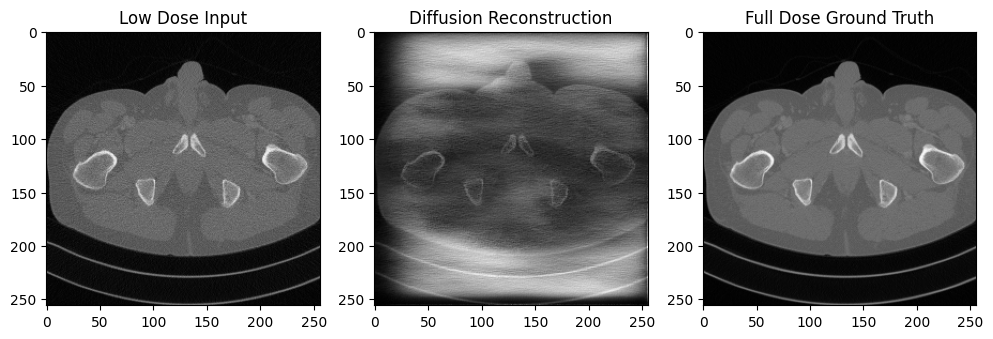

In [35]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.title("Low Dose Input")
plt.imshow(low_img.squeeze().cpu().numpy(), cmap='gray')
plt.subplot(1,3,2)
plt.title("Diffusion Reconstruction")
plt.imshow(denoised.squeeze().cpu().numpy(), cmap='gray')
plt.subplot(1,3,3)
plt.title("Full Dose Ground Truth")
plt.imshow(full_img.squeeze().cpu().numpy(), cmap='gray')

plt.show()


In [36]:
den = denoised.squeeze().cpu().numpy().astype(np.float64)   # [H,W]
gt  = full_img.squeeze().cpu().numpy().astype(np.float64)      # [H,W]
print("PSNR (diffusion):", psnr(gt, den))
print("SSIM (diffusion):", ssim(gt, den))

PSNR (diffusion): 40.7273170105062
SSIM (diffusion): 0.5736477628391918
